In [1]:
import sys   ###qmdp1（上の2つのセル）
sys.path.append('../scripts/')
from dynamic_programming import *
from dp_policy_agent import *
from mcl import *

In [22]:
class QmdpAgent(MclAgent):
    def __init__(self, time_interval, pf, goal, puddles, sampling_num=10, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 puddle_coef=100.0, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T): 
        super().__init__(time_interval, 0.0, 0.0, pf)
        self.dp = DynamicProgramming(widths, goal, puddles, time_interval, sampling_num)     #dpのオブジェクトを持たせる
        self.dp.policy = DpPolicyAgent.init_policy(self.dp.index_nums)                                          #policyを読み込んで使う
        self.in_goal = False                                                                                                                    #定義しておくと自動でゴールを教えてもらえる
        
    def policy(self, pose):             #方策を参照して返すだけ
        return self.dp.policy[DpPolicyAgent.to_index(pose, self.dp.pose_min, self.dp.index_nums, self.dp.widths)]
        
    def decision(self, observation=None): #dp_policy_agent.ipynbから持ってきてMCLを使うように変更（kfからpfに）
        if self.in_goal:                                    #ゴールで止まる
            return 0.0, 0.0
        
        self.pf.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.pf.observation_update(observation)
        nu, omega = self.policy(self.pf.ml.pose)          #self.pf.ml.poseに変更
        self.prev_nu, self.prev_omega = nu, omega
        return nu, omega

<IPython.core.display.Javascript object>


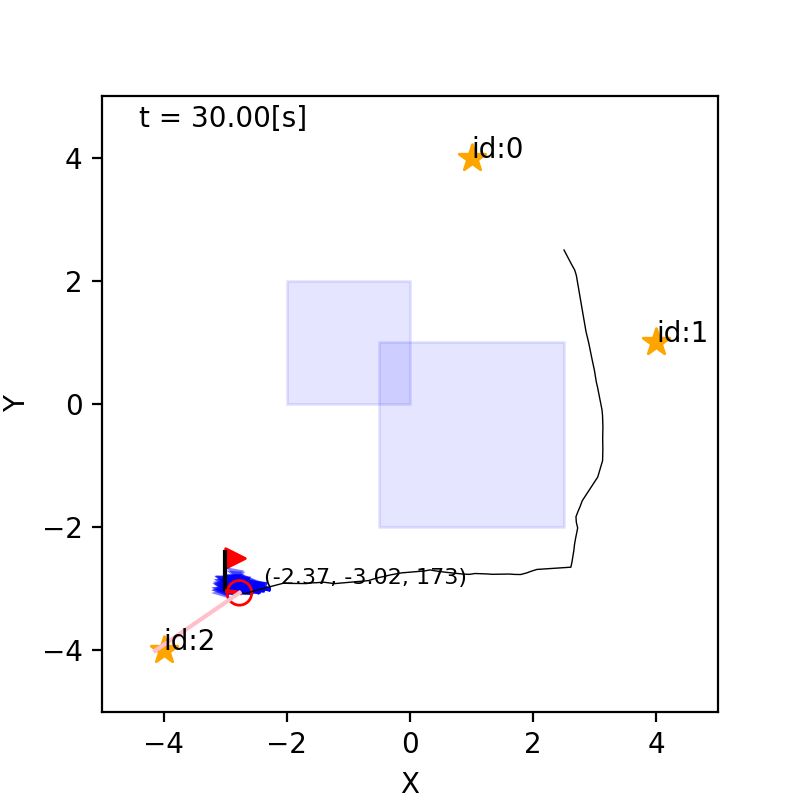

In [26]:
if __name__ == '__main__':  ###qmdp1exec
    time_interval = 0.1
    world = PuddleWorld(30, time_interval, debug=False) 

    ##ランドマークの追加（意地悪な位置に）##
    m = Map()
    m.append_landmark(Landmark(1,4))
    m.append_landmark(Landmark(4,1))
    m.append_landmark(Landmark(-4,-4))
    world.append(m)
    
    ##ゴール・水たまりの追加（これは特に変更なし）##
    goal = Goal(-3,-3)
    puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)] 
    world.append(goal)
    world.append(puddles[0]) 
    world.append(puddles[1])
    
    ##ロボットを作る##
    init_pose = np.array([2.5, 2.5, 0]).T
    pf = Mcl(m, init_pose, 100)
    a = QmdpAgent(time_interval, pf, goal, puddles)
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")

    world.append(r)
        
    world.draw()